In [1]:
import torch
import numpy as np
import networkx as nx
import torch.nn as nn
import time
import torch.nn.functional as F

In [2]:
from utils import EarlyStopping

## Load Data

In [3]:
from torch_geometric.datasets import Planetoid

In [4]:
path = %pwd

In [5]:
Cora = Planetoid(root=path, name='Cora')
cora = Cora[0]

In [ ]:
C_S = Planetoid(root=path, name='CiteSeer')
cite_seer = C_S[0]

In [ ]:
PM = Planetoid(root=path, name='PubMed')
pub_med = PM[0]

In [6]:
def Gen_data(dataset, num_features,seed):
    np.random.seed(seed)
    data = dataset.clone()
    rx = np.random.normal(0, 1, size=(data.num_nodes, num_features) )
    #rx = np.random.random((data.num_nodes, num_features))
    rx = torch.FloatTensor(rx)
    data.x = rx
    return data

In [7]:
# Cora
cora_seed = 1024
N_F = 300
r_cora = Gen_data(cora, N_F, cora_seed)

data = r_cora
num_features = data.num_features
num_classes = len(set(data.y.numpy()))

In [ ]:
#Cite_Seer
cite_seer_seed = 1024
N_F = 500
r_citeseer = Gen_data(cite_seer, N_F, cite_seer_seed)

data = r_citeseer
num_features = data.num_features
num_classes = len(set(data.y.numpy()))

In [ ]:
#pubmed
pub_med_seed = 1024
N_F = 1000
r_pubmed = Gen_data(pub_med, N_F, pub_med_seed)

data = r_pubmed
num_features = data.num_features
num_classes = len(set(data.y.numpy()))

## D_inv_A

In [8]:
from D_inv_A import D_inv_AConv

In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = D_inv_AConv(
            num_features, num_classes, K=60, cached=True, improve= True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

In [10]:
das = []
for _ in range(10):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model, data = Net().to(device), data.to(device)
  #r_cora_da
  optimizer = torch.optim.Adam(model.parameters(), lr=0.3, weight_decay=5e-3)
  #pubmed_da
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=5e-5)
  #cite_seer_da
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.09, weight_decay=5e-3)
 

  def train():
      model.train()
      optimizer.zero_grad()
      loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

  def test(mask):
      model.eval()
      with torch.no_grad():
          logits = model()
          pred = logits[mask].max(1)[1]
          acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
          
      return acc


  early_stop = True
  if early_stop:
      stopper = EarlyStopping(patience=100)
  dur = []
  print(model)

  for epoch in range(1, 101):
      model.train()
      if epoch >= 3:
          t0 = time.time()
      loss = train()
      
      if epoch >= 3:
          dur.append(time.time() - t0)
      
      val_acc = test(data.val_mask)
      
      if early_stop:
          if stopper.step(val_acc, model):   
              break
      
      '''print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | "
                " ValAcc {:.4f}".
                format(epoch, np.mean(dur), loss, val_acc))'''
      
  print() # 空出一行
      
  if early_stop:
      model.load_state_dict(torch.load('es_checkpoint.pt'))
  test_acc = test(data.test_mask)
  das.append(test_acc)
  print("Test Accuracy {:.4f}".format(test_acc))

Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7190
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7150
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7040
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.6920
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7150
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.6990
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.6930
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7240
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7160
Net(
  (conv1): D_inv_AConv(300, 7, K=60)
)

Test Accuracy 0.7290


In [11]:
np.mean(das)

0.7106

In [12]:
np.std(das)*100

1.2208193969625496

## load previously results: Iteration5-60, Feature dim = 300

In [13]:
DA = np.loadtxt('DA_5_60_cora_300.txt')

In [14]:
DA.shape

(12, 2)

In [15]:
DA

array([[6.04000000e-01, 4.32049380e-03],
       [6.99333333e-01, 4.18993503e-03],
       [7.44333333e-01, 4.71404521e-04],
       [7.55000000e-01, 4.54606057e-03],
       [7.53666667e-01, 7.40870359e-03],
       [7.38000000e-01, 1.63299316e-03],
       [7.55000000e-01, 6.37704216e-03],
       [7.47333333e-01, 9.67241209e-03],
       [7.31666667e-01, 1.04986772e-02],
       [7.14333333e-01, 1.69967317e-03],
       [7.28000000e-01, 1.48548533e-02],
       [7.12333333e-01, 5.31245915e-03]])

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
DA[:,1].shape

(12,)

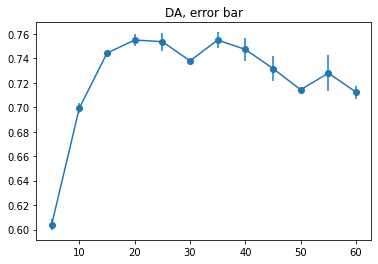

In [18]:
x = np.arange(5,65,5)
y = DA[:,0]
# example error bar values that vary with x-position
error =DA[:,1]

fig, ax = plt.subplots(nrows=1)
ax.errorbar(x, y, yerr=error, fmt='-o')
ax.set_title('DA, error bar')

plt.show()

### Introduction Part: Random Feature Test

## D_A_D/Linear GCN

In [19]:
from D_A_D import DAD_Conv

In [20]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = DAD_Conv(
            num_features, num_classes, K=40, cached=True, improve=True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

In [21]:
Dads = []
for _ in range(10):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model, data = Net().to(device), data.to(device)
  #r_cora_dad
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-6)
  #pubmed_dad
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=5e-4)
  #r_cite_seer_dad
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=5e-2)
  

  def train():
      model.train()
      optimizer.zero_grad()
      loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

  def test(mask):
      model.eval()
      with torch.no_grad():
          logits = model()
          pred = logits[mask].max(1)[1]
          acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
          
      return acc


  early_stop = True
  if early_stop:
      stopper = EarlyStopping(patience=100)
  dur = []
  print(model)

  for epoch in range(1, 101):
      model.train()
      if epoch >= 3:
          t0 = time.time()
      loss = train()
      
      if epoch >= 3:
          dur.append(time.time() - t0)
      
      val_acc = test(data.val_mask)
      
      if early_stop:
          if stopper.step(val_acc, model):   
              break
      
      '''print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | "
                " ValAcc {:.4f}".
                format(epoch, np.mean(dur), loss, val_acc))'''
      
  print() 
      
  if early_stop:
      model.load_state_dict(torch.load('es_checkpoint.pt'))
  test_acc = test(data.test_mask)
  Dads.append(test_acc)
  print("Test Accuracy {:.4f}".format(test_acc))

hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7350
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7350
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7350
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7330
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7360
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7350
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7380
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7340
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7330
hola!
Net(
  (conv1): DAD_Conv(300, 7, K=40)
)

Test Accuracy 0.7330


In [22]:
np.mean(Dads)

0.7346999999999999

In [23]:
np.std(Dads)*100

0.14866068747318517

## RWN

In [24]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import remove_self_loops, add_self_loops,softmax
from torch_geometric.nn.conv import MessagePassing

In [25]:
# L2 normalized weights
def Rand_aw(G, n=1):
    #np.random.seed(1024)
    A = nx.to_numpy_array(G, nodelist=range(len(G))) 
    w = np.random.random(A.shape)
    A = A*w + n*np.eye(A.shape[0])
    row_sum = np.sum(A**2, axis=1,keepdims=True)
    A = A/(np.sqrt(row_sum)+1e-12)
    return A

In [26]:
data.to('cpu')
edge_index, _ = remove_self_loops(data.edge_index)
edge_index, _ = add_self_loops(edge_index, num_nodes=data.num_nodes)
edges = edge_index.numpy().T
# create a graph and feed it to Rand_aw
rg = nx.Graph()

rg.add_edges_from(edges)

In [27]:
class rw_GNN(MessagePassing):
    def __init__(self, in_channels, out_channels, rw, k=3, cached=True, bias=True,
                 **kwargs):
                 
        super(rw_GNN, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k
        self.cached = cached
        self.lin = Linear(in_channels, out_channels, bias=bias)

        if not torch.is_tensor(rw):
                rw = torch.tensor(rw, dtype=data.x.dtype)
        self.rw = rw.cuda()

        self.reset_parameters()

        
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.cached_result = None
        self.cached_num_edges = None

    def forward(self, x, edge_index):
        """"""
        #x = self.lin(x) #训练阶段更新权重部分

        # 训练时跳过的代码
        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            #edge_index 处理好
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            #权值对齐
            #rw的索引array与tensor均可
            norm = self.rw[edge_index[1], edge_index[0]]
            #按流向，信息是0行->1行；1⃣️1行为中心进行信息接收，所以权重以1行索引为首！
            #print(norm.dtype)
            
            # x是特征--迭代初始space； 而x_norm 是用来计算权值矩阵/相似度矩阵的！
            for k in range(self.k):
                x = self.propagate(edge_index, x=x, norm=norm) 
            self.cached_result = x

        #训练阶段更新权重部分
        if self.cached:
            x = self.lin(self.cached_result)
        return x
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def __repr__(self):
        return '{}({}, {}, K={})'.format(self.__class__.__name__,
                                         self.in_channels, self.out_channels,
                                         self.k)

In [28]:
aw = Rand_aw(rg, n=1)

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = rw_GNN(
            num_features, num_classes, rw=aw , k=60, cached=True)

    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [30]:
das = []
for _ in range(10):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model, data = Net().to(device), data.to(device)

  #cora_pytorch
  optimizer = torch.optim.Adam(model.parameters(), lr=0.3, weight_decay=5e-3)
  #pubmed
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-3)
  #pubmed_norm
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.3, weight_decay=5e-6)
  #cite_seer,
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.08, weight_decay=5e-1)
  def train():
      model.train()
      optimizer.zero_grad()
      loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

  def test(mask):
      model.eval()
      with torch.no_grad():
          logits = model()
          pred = logits[mask].max(1)[1]
          acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
          
      return acc


  early_stop = True
  if early_stop:
      stopper = EarlyStopping(patience=100)
  dur = []
  #print(model)

  for epoch in range(1, 101):
      model.train()
      if epoch >= 3:
          t0 = time.time()
      loss = train()
      
      if epoch >= 3:
          dur.append(time.time() - t0)
      
      val_acc = test(data.val_mask)
      
      if early_stop:
          if stopper.step(val_acc, model):   
              break
      
      
  if early_stop:
      model.load_state_dict(torch.load('es_checkpoint.pt'))
  test_acc = test(data.test_mask)
  das.append(test_acc)
  print("Test Accuracy {:.4f}".format(test_acc))

Test Accuracy 0.1350
Test Accuracy 0.0740
Test Accuracy 0.0670
Test Accuracy 0.1420
Test Accuracy 0.1470
Test Accuracy 0.1160
Test Accuracy 0.1560
Test Accuracy 0.1500
Test Accuracy 0.1400
Test Accuracy 0.1500


In [31]:
np.mean(das), np.std(das)*100

(0.12769999999999998, 3.046653902234384)

## load previously results: Iteration5-60, Feature dim = 300

In [33]:
RMN = np.loadtxt('RWN_5_60_cora_300.txt')

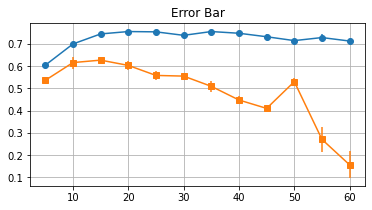

In [34]:
x = np.arange(5,65,5)
y0 = DA[:,0]
# example error bar values that vary with x-position
error0 =DA[:,1]


y1= RMN[:,0]
# example error bar values that vary with x-position
error1 =RMN[:,1]

fig, ax = plt.subplots(figsize=(6,3))
plt.grid(True)
ax.errorbar(x, y0, yerr=error0, fmt='-o')
ax.errorbar(x, y1, yerr=error1, fmt='-s')

ax.set_title('Error Bar');